In [722]:
import pandas as pd
df=pd.read_csv('data/classification.csv')

In [723]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [724]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

FILLING NULL VALUES

In [725]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro,ks_2samp,norm
from scipy.spatial.distance import cdist
import math

class Preprocessor:

    # Attributes: df (Original DataFrame),  descriptor (Dataframe containing information about Null Values and Feature data type)
    # Methods : Called from outside: __inti__(df), fillNull()
    
    def __init__(self,df):
        self.df=df.copy()
        self.descriptor=self.generateDescriptor()
    
    def generateDescriptor(self):    # Generates descriptor df
        descriptor_df = pd.DataFrame(self.df.isnull().sum())
        descriptor_df[1] = round(descriptor_df[0]/self.df.shape[0],2)*100
        isNumerical=[]
        for column in self.df.columns:
            if self.df[column].dtype == 'int64' or self.df[column].dtype == 'float64':
                isNumerical.append(1)
            else:
                isNumerical.append(0)
        descriptor_df[2]=isNumerical
        return descriptor_df

    def checkDistribution(self,series):    # Labels feature distribution as Normal or Skewed
        if abs(series.skew())<0.5:
            return "normal"
        else:
            if series.shape[0]<5000:
                stat,p = shapiro(series)
            else:
                mu,sigma=series.mean(),series.std()
                stat,p = ks_2samp(series,norm.rvs(loc=mu,scale=sigma,size=len(series)))
            if p>0.05:
                return "normal"
            else:
                return "skewed"    

    def is_id_column(self,feature_series):    # Checks if feature is ID type
        value_range = feature_series.max() - feature_series.min()
        unique_count = feature_series.nunique()
        if unique_count == len(feature_series):
            if abs(value_range - unique_count) < 2:
                return True
        return False

    def knnImpute(self,df,descriptor_df,feature):    # KNN imputation based on categorical or numerical feature
        neighbour_features = [
            it for it in descriptor_df.index
            if descriptor_df[0][it] == 0
            and descriptor_df[2][it] == 1
            and not self.is_id_column(df[it])
            ]
    
        neighbour_df=df[neighbour_features]
        non_null=neighbour_df[df[feature].notna()]
        null=neighbour_df[df[feature].isna()]
        norm_min=neighbour_df.min()
        norm_range=neighbour_df.max()-neighbour_df.min()
        norm_range.replace(0,1e-9,inplace=True)
        non_null=(non_null-norm_min)/norm_range
        null=(null-norm_min)/norm_range
        distances = pd.DataFrame(cdist(null,non_null,metric='euclidean'))
        k=math.ceil(math.sqrt(non_null.shape[0]))
        k_nearest_indices= pd.DataFrame(np.argsort(distances,axis=1)).iloc[:,:k]
        
        for enumerated_null_index,df_index in enumerate(null.index):
            enumerated_non_null_indices=k_nearest_indices.loc[enumerated_null_index]
            true_df_indices=non_null.iloc[enumerated_non_null_indices].index
            neighbour_values = df[feature].loc[true_df_indices]
            if descriptor_df[2][feature]==1 and self.df[feature].nunique()/len(self.df[feature])>0.05:
                df.loc[df_index, feature] = neighbour_values.mean()
            else:
                df.loc[df_index, feature] = neighbour_values.mode().iloc[0]
        
    def fill_null(self):
        for feature in self.descriptor.index:
            
            if self.descriptor[1][feature]>30:    # Feature has more than 30% null values
                self.df.drop(feature,axis=1,inplace=True)    # Remove feature
                self.descriptor = self.generateDescriptor()    # Remake descriptor df
                continue
                
            if self.descriptor[2][feature]==1:    # Numerical feature
                
                if self.descriptor[1][feature]>5:    # Null values between 5-30%
                    self.knnImpute(self.df,self.descriptor,feature)    # Use KNN
                    
                else:    # Null values between less than 5%
                    if self.df[feature].nunique()/len(self.df[feature])<0.05:    # Ordinal Feature (Discrete Finite numerical)
                        self.df.loc[:, feature] = self.df[feature].fillna(self.df[feature].mode().iloc[0]).copy()   # Fill with mode
                        
                    elif self.checkDistribution(self.df[feature]) == 'normal':    # Normal numerical fetaure
                        self.df.loc[:, feature] = self.df[feature].fillna(self.df[feature].mean()).copy()    # Fill with mean
                        
                    else:    # Skewed numerical feature
                        self.df.loc[:, feature] = self.df[feature].fillna(self.df[feature].median()).copy()    # Fill with median
                        
            else:    # Categorical feature
                if self.descriptor[1][feature]>5:    # Null values between 5-30%
                    self.knnImpute(self.df,self.descriptor,feature)    # Use KNN
                    
                else:    # Null values between less than 5%
                    self.df.loc[:, feature] = self.df[feature].fillna(self.df[feature].mode().iloc[0]).copy()   # Fill with mode

                    
        self.descriptor=self.generateDescriptor()    # Remake descriptor df
        return self.df


In [726]:
pre=Preprocessor(df)
df1=pre.fill_null()
df1.isnull().sum()


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

TRAIN TEST SPLIT

In [727]:
class Split:
    def __init__(self, df):
        self.df = df.copy()

    def X_y_split(self, target_feature):
        if target_feature in self.df.columns:
            y = self.df[target_feature]
            X = self.df.drop(columns=[target_feature])
            return X, y
        else:
            print(f"'{target_feature}' is not a feature of the given dataset.")
            return None, None

    def train_test_split(self, X, y, test_size=0.2, random_state=42):
        np.random.seed(random_state)
        indices = np.random.permutation(len(X))

        test_count = int(len(X) * test_size)
        test_idx, train_idx = indices[:test_count], indices[test_count:]

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        return X_train, X_test, y_train, y_test


In [729]:
sp=Split(df1)
X,y=sp.X_y_split('Survived')

In [730]:
X.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [731]:
y.head(2)

0    0
1    1
Name: Survived, dtype: int64

In [732]:
X_train,X_test,y_train,y_test=sp.train_test_split(X,y)

In [733]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(713, 10)
(713,)
(178, 10)
(178,)


FEATURE ENGINEERING (Useless for now)

In [734]:
from dateutil import parser
import pandas as pd
import numpy as np

class FeatureEngineering:
    def __init__(self, df):
        self.df = df.copy()

    @staticmethod
    def safe_parse_date(date_str):
        try:
            return parser.parse(date_str)
        except (ValueError, TypeError):
            return None

    def extract_datetime_features(self):
        datetime_cols = self.df.select_dtypes(include=['object']).columns.tolist()
        datetime_cols = [col for col in datetime_cols if self.df[col].str.contains(r'\d', na=False, regex=True).any()]
        
        new_features = {}

        for col in datetime_cols:
            self.df[col] = self.df[col].apply(lambda x: FeatureEngineering.safe_parse_date(x) if pd.notna(x) else None)
            self.df[col] = pd.to_datetime(self.df[col], errors='coerce')

            valid_rows = self.df[col].notna()
            if valid_rows.sum() < 0.3 * self.df.shape[0]:  # Keep only columns with enough valid dates
                continue

            new_features[f"{col}_year"] = self.df[col].dt.year
            new_features[f"{col}_month"] = self.df[col].dt.month
            new_features[f"{col}_day"] = self.df[col].dt.day
            new_features[f"{col}_weekday"] = self.df[col].dt.weekday
            new_features[f"{col}_hour"] = self.df[col].dt.hour
            self.df.drop(columns=[col], inplace=True)

        if new_features:
            self.df = pd.concat([self.df, pd.DataFrame(new_features, index=self.df.index)], axis=1)

        return self

    def extract_text_features(self):
        text_cols = self.df.select_dtypes(include=['object']).columns
        new_features = {}

        for col in text_cols:
            if self.df[col].isna().all():
                continue
            new_features[f"{col}_char_count"] = self.df[col].astype(str).apply(len)
            new_features[f"{col}_word_count"] = self.df[col].astype(str).apply(lambda x: len(x.split()))

        if new_features:
            self.df = self.df.assign(**new_features)
        
        return self
    
    def create_interaction_features(self):
        num_cols = self.df.select_dtypes(include=[np.number]).columns
        new_features = {}
    
        if len(num_cols) > 1:
            for i in range(len(num_cols)):
                for j in range(i + 1, len(num_cols)):
                    col1, col2 = num_cols[i], num_cols[j]
    
                    # Basic multiplicative interaction
                    new_features[f"{col1}_x_{col2}"] = self.df[col1].fillna(0) * self.df[col2].fillna(0)
                    
                    # Additive interaction
                    new_features[f"{col1}_plus_{col2}"] = self.df[col1].fillna(0) + self.df[col2].fillna(0)
                    
                    # Ratio interaction (avoid division by zero)
                    new_features[f"{col1}_div_{col2}"] = self.df[col1] / (self.df[col2] + 1e-9)
                    new_features[f"{col2}_div_{col1}"] = self.df[col2] / (self.df[col1] + 1e-9)
    
        if new_features:
            self.df = pd.concat([self.df, pd.DataFrame(new_features, index=self.df.index)], axis=1).copy()
        return self

    def create_statistical_features(self):
        num_cols = self.df.select_dtypes(include=[np.number]).columns
        if len(num_cols) == 0:
            return self

        self.df["num_mean"] = self.df[num_cols].mean(axis=1)
        self.df["num_std"] = self.df[num_cols].std(axis=1)
        self.df["num_median"] = self.df[num_cols].median(axis=1)
        
        return self

    def encode_categorical_features(self):
        cat_cols = self.df.select_dtypes(include=['object']).columns
        new_features = {}

        for col in cat_cols:
            counts = self.df[col].value_counts().to_dict()
            freqs = self.df[col].map(self.df[col].value_counts(normalize=True))
            
            new_features[f"{col}_count"] = self.df[col].map(counts)
            new_features[f"{col}_freq"] = freqs

        if new_features:
            self.df = self.df.assign(**new_features)
        
        return self

    def transform(self):
        self.df.dropna(axis=1, how='any', inplace=True)  # Drops all columns with any NaN values
        return self.df

    def automated_feature_engineering(self):
        return (
            self.extract_datetime_features()
            .extract_text_features()
            .create_interaction_features()
            .create_statistical_features()
            .encode_categorical_features()
            .transform()
        )

In [735]:
X_train_fe=FeatureEngineering(X_train).automated_feature_engineering()
X_test_fe = FeatureEngineering(X_test).automated_feature_engineering()

In [736]:
X_train_fe.shape

(713, 288)

In [737]:
X_test_fe.shape

(178, 288)

ENCODING

In [745]:
class SimpleEncoder:  
    """ ONLY USE FOR UNSUPERVISED LEARNING """
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.y_train = y_train.copy()
        self.y_test = y_test.copy()
        self.encoding_type = self.generateEncodingType()

    def generateEncodingType(self): 
        categorical_columns = self.X_train.select_dtypes(include=['object']).columns.tolist()
        encoding_type = {}
        for column in categorical_columns:
            if self.X_train[column].nunique() < 10:
                encoding_type[column] = 'OHE'
            else:
                encoding_type[column] = 'frequency'
        return encoding_type

    def oneHotEncoding(self, features):
        self.X_train = pd.get_dummies(self.X_train, columns=features, drop_first=True)
        self.X_test = pd.get_dummies(self.X_test, columns=features, drop_first=True)
        self.X_test = self.X_test.reindex(columns=self.X_train.columns, fill_value=0)  # Align test with train

    def frequencyEncoding(self, features):
        for feature in features:
            freqs = self.X_train[feature].value_counts(normalize=True)
            self.X_train[feature + '_freq'] = self.X_train[feature].map(freqs)
            self.X_test[feature + '_freq'] = self.X_test[feature].map(freqs).fillna(0)
        self.X_train.drop(columns=features, inplace=True)
        self.X_test.drop(columns=features, inplace=True)

    def encode_input(self):
        OHE = []
        freq = []
        for feature in self.encoding_type.keys():  
            if self.encoding_type[feature] == 'OHE':
                OHE.append(feature)
            else:
                freq.append(feature)

        self.oneHotEncoding(OHE)
        self.frequencyEncoding(freq)
        return self.X_train, self.X_test

    def encode_output(self):
        if self.y_train.dtype == 'object':
            unique_classes = self.y_train.unique()
            class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
            self.y_train = self.y_train.map(class_mapping)
            self.y_test = self.y_test.map(lambda x: class_mapping.get(x, -1))  # -1 --> unseen classes 
        return self.y_train, self.y_test


class TargetEncoder:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.y_train = y_train.copy()
        self.y_test = y_test.copy()
        self.target_features = self.X_train.select_dtypes(include=['object']).columns.tolist()
        self.encoding_map = {}

    def fit(self, features):
        df_train = self.X_train.copy()
        df_train["target"] = self.y_train  # Temporarily add y_train to X_train

        for feature in features:
            means = df_train.groupby(feature)["target"].mean()  # Now "target" exists in df_train
            self.encoding_map[feature] = means.to_dict()

    def transform(self, X, features):
        X_encoded = X.copy()
        for feature in features:
            X_encoded[feature + '_target'] = X_encoded[feature].map(self.encoding_map.get(feature, {})).fillna(self.y_train.mean())
        X_encoded.drop(columns=features, inplace=True)
        return X_encoded

    def encode_input(self):
        self.fit(self.target_features)
        self.X_train = self.transform(self.X_train, self.target_features)
        self.X_test = self.transform(self.X_test, self.target_features)
        return self.X_train, self.X_test

    def encode_output(self):
        if self.y_train.dtype == 'object':
            unique_classes = self.y_train.unique()
            class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
            self.y_train = self.y_train.map(class_mapping)
            self.y_test = self.y_test.map(lambda x: class_mapping.get(x, -1))  # Assign -1 to unseen classes 
        return self.y_train, self.y_test

In [747]:
te=TargetEncoder(X_train,X_test,y_train,y_test)
Xtrain_te,Xtest_te=te.encode_input()

In [748]:
y_train,y_test=se.encode_output()

SCALING

In [749]:
class StandardScalerCustom:
    def __init__(self,X_train,X_test):
        self.means = None
        self.stds = None
        
        constant_train = set(X_train.columns[X_train.nunique() == 1])
        constant_test = set(X_test.columns[X_test.nunique() == 1])
        self.columns_to_drop = list(constant_train & constant_test)
        
        self.X_train = X_train.drop(columns=self.columns_to_drop, errors='ignore')
        self.X_test = X_test.drop(columns=self.columns_to_drop, errors='ignore')
    
    def fit(self, X):
        self.means = X.mean()
        self.stds = X.std(ddof=0)  # Population std (ddof=0) to match sklearn
        
        
    
    def transform(self, X):
        return (X - self.means) / self.stds
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def scale_features(self):
        X_train_scaled = self.fit_transform(self.X_train)
        X_test_scaled = self.transform(self.X_test)
        return X_train_scaled, X_test_scaled


In [750]:
ss=StandardScalerCustom(Xtrain_te,Xtest_te)
X_train_scaled,X_test_scaled = ss.scale_features()

In [751]:
X_train_scaled

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name_target,Sex_target,Ticket_target,Embarked_target
10,-1.699625,0.812087,-1.857390,0.379618,0.783811,-0.305665,1.284740,1.377815,1.387210,-0.49536
331,-0.450076,-1.615661,1.177396,-0.471538,-0.480572,-0.078304,-0.778367,-0.725787,-0.840449,-0.49536
733,1.114779,-0.401787,-0.467970,-0.471538,-0.480572,-0.376956,-0.778367,-0.725787,-0.840449,-0.49536
382,-0.251550,0.812087,0.190176,-0.471538,-0.480572,-0.474740,-0.778367,-0.725787,-0.840449,-0.49536
704,1.001892,0.812087,-0.248588,0.379618,-0.480572,-0.476104,-0.778367,-0.725787,-0.840449,-0.49536
...,...,...,...,...,...,...,...,...,...,...
106,-1.325928,0.812087,-0.614225,-0.471538,-0.480572,-0.480038,1.284740,1.377815,1.387210,-0.49536
270,-0.687529,-1.615661,1.578242,-0.471538,-0.480572,-0.030135,-0.778367,-0.725787,-0.840449,-0.49536
860,1.609149,0.812087,0.848323,1.230775,-0.480572,-0.355601,-0.778367,-0.725787,-0.840449,-0.49536
435,-0.045238,-1.615661,-1.126116,0.379618,2.048194,1.684702,1.284740,1.377815,1.387210,-0.49536


FEATURE SELECTION

In [752]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

class FeatureSelection:
    def __init__(self, X_train, X_test, y_train, y_test, problem, corr_threshold=0.95, importance_threshold=0.01):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.y_train = y_train
        self.y_test = y_test
        self.problem = problem
        self.corr_threshold = corr_threshold
        self.importance_threshold = importance_threshold
        
    def remove_low_variance_features(self):
        variances = self.X_train.var()
        low_var_cols = variances[variances < 1e-5].index
        self.X_train.drop(columns=low_var_cols, inplace=True)
        self.X_test.drop(columns=low_var_cols, inplace=True)
        print(f"Removed {len(low_var_cols)} low-variance features.")

    def remove_highly_correlated_features(self):
        corr_matrix = self.X_train.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > self.corr_threshold)]
        self.X_train.drop(columns=to_drop, inplace=True)
        self.X_test.drop(columns=to_drop, inplace=True)
        print(f"Removed {len(to_drop)} highly correlated features.")

    def select_important_features(self):
        if self.problem == 'classification':
            model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            mi_func = mutual_info_classif
        elif self.problem == 'regression':
            model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            mi_func = mutual_info_regression
        else:
            raise ValueError("Invalid problem type. Choose 'classification' or 'regression'.")
        
        model.fit(self.X_train, self.y_train)
        feature_importances = pd.Series(model.feature_importances_, index=self.X_train.columns)
        selected_features = feature_importances[feature_importances > self.importance_threshold].index
        
        # Mutual Information as a backup check
        mi_scores = mi_func(self.X_train, self.y_train)
        mi_selected_features = self.X_train.columns[mi_scores > 0]
        
        # Intersection of both methods
        final_features = list(set(selected_features) & set(mi_selected_features))
        self.X_train = self.X_train[final_features]
        self.X_test = self.X_test[final_features]
        print(f"Selected {len(final_features)} important features.")

    def transform(self):
        self.remove_low_variance_features()
        self.remove_highly_correlated_features()
        self.select_important_features()
        return self.X_train, self.X_test

In [755]:
fs = FeatureSelection(X_train_scaled,X_test_scaled,y_train,y_test,'classification')

In [756]:
X_train_new,X_test_new = fs.transform()

Removed 0 low-variance features.
Removed 0 highly correlated features.
Selected 6 important features.


In [757]:
X_train_new

,Ticket_target,Sex_target,Age,Fare,Name_target,Pclass
10,1.387210,1.377815,-1.857390,-0.305665,1.284740,0.812087
331,-0.840449,-0.725787,1.177396,-0.078304,-0.778367,-1.615661
733,-0.840449,-0.725787,-0.467970,-0.376956,-0.778367,-0.401787
382,-0.840449,-0.725787,0.190176,-0.474740,-0.778367,0.812087
704,-0.840449,-0.725787,-0.248588,-0.476104,-0.778367,0.812087
...,...,...,...,...,...,...
106,1.387210,1.377815,-0.614225,-0.480038,1.284740,0.812087
270,-0.840449,-0.725787,1.578242,-0.030135,-0.778367,-1.615661
860,-0.840449,-0.725787,0.848323,-0.355601,-0.778367,0.812087
435,1.387210,1.377815,-1.126116,1.684702,1.284740,-1.615661


In [758]:
X_test_new

,Ticket_target,Sex_target,Age,Fare,Name_target,Pclass
709,0.000000,-0.725787,-1.158834,-0.333684,0.0,0.812087
439,0.000000,-0.725787,0.117049,-0.425125,0.0,-0.401787
840,0.000000,-0.725787,-0.687352,-0.474740,0.0,0.812087
720,0.273380,1.377815,-1.711135,0.008401,0.0,-0.401787
39,1.387210,1.377815,-1.126116,-0.410834,0.0,0.812087
...,...,...,...,...,...,...
852,-0.840449,1.377815,-1.491753,-0.333684,0.0,0.812087
433,0.000000,-0.725787,-0.906734,-0.490154,0.0,0.812087
773,0.000000,-0.725787,0.081839,-0.488227,0.0,0.812087
25,0.644657,1.377815,0.628941,-0.022669,0.0,0.812087


DIMENSIONALITY REDUCTION

In [762]:
import numpy as np
import pandas as pd

class DimensionalityReduction:
    def __init__(self, X_train_scaled, X_test_scaled, y_train=None, task_type='classification'):
        self.X_train_scaled = X_train_scaled
        self.X_test_scaled = X_test_scaled
        self.y_train = y_train
        self.task_type = task_type.lower()
        self.feature_importance = pd.DataFrame()

        print("Any NaNs in X_train_scaled?", X_train_scaled.isna().sum().sum() > 0)
        print("Any infinities in X_train_scaled?", np.isinf(X_train_scaled.values).sum() > 0)

    def choose_pca_components(self, eigenvals, threshold=0.95):
        explained = np.cumsum(eigenvals) / np.sum(eigenvals)
        return np.searchsorted(explained, threshold) + 1

    def apply_pca(self):
        cov = np.cov(self.X_train_scaled, rowvar=False)
        eigenvals, eigenvecs = np.linalg.eigh(cov)
        
        idxs = np.argsort(eigenvals)[::-1]
        eigenvals, eigenvecs = eigenvals[idxs], eigenvecs[:, idxs]

        n_components = self.choose_pca_components(eigenvals)
        components = eigenvecs[:, :n_components]
        components_weightage = eigenvals[:n_components]
        
        contribution_matrix = components**2 * components_weightage
        importance = np.sum(contribution_matrix, axis=1)
        importance_percentage = (importance / np.sum(importance)) * 100
        
        importance_idxs = np.argsort(importance_percentage)[::-1]
        self.feature_importance['Feature'] = self.X_train_scaled.columns[importance_idxs]
        self.feature_importance['% Variance Explained'] = importance_percentage[importance_idxs]
        
        return self.X_train_scaled @ components, self.X_test_scaled @ components

    def apply_lda(self):
        classes = np.unique(self.y_train)
        mean_vectors = {c: np.mean(self.X_train_scaled[self.y_train == c], axis=0) for c in classes}
        overall_mean = np.mean(self.X_train_scaled, axis=0)
        
        S_W, S_B = np.zeros((self.X_train_scaled.shape[1], self.X_train_scaled.shape[1])), np.zeros((self.X_train_scaled.shape[1], self.X_train_scaled.shape[1]))
        
        for c in classes:
            class_scatter = np.cov(self.X_train_scaled[self.y_train == c], rowvar=False) * (self.X_train_scaled[self.y_train == c].shape[0] - 1)
            S_W += class_scatter
            
            mean_diff = (mean_vectors[c].values - overall_mean.values).reshape(-1, 1)
            S_B += (self.X_train_scaled[self.y_train == c].shape[0] * (mean_diff @ mean_diff.T))
        
        S_W_inv = np.linalg.pinv(S_W)
        eigvals, eigvecs = np.linalg.eigh(S_W_inv @ S_B)
        
        idxs = np.argsort(eigvals)[::-1]
        eigvecs = eigvecs[:, idxs]
        
        importance = np.abs(eigvecs[:, 0])
        importance_percentage = (importance / np.sum(importance)) * 100
        
        feature_order = np.argsort(importance_percentage)[::-1]
        self.feature_importance['Feature'] = self.X_train_scaled.columns[feature_order]
        self.feature_importance['Discrimination Power'] = importance_percentage[feature_order]
        
        return self.X_train_scaled @ eigvecs[:, :len(classes) - 1], self.X_test_scaled @ eigvecs[:, :len(classes) - 1]
    
    def apply(self):
        if self.task_type == 'classification':
            return self.apply_lda()
        elif self.task_type == 'regression':
            return self.apply_pca()
        else:
            raise ValueError("Invalid task_type. Choose either 'classification' or 'regression'.")


In [765]:
dr = DimensionalityReduction(X_train_new, X_test_new,y_train,'classification')

Any NaNs in X_train_scaled? False
Any infinities in X_train_scaled? False


In [768]:
X_train_dr,X_test_dr = dr.apply()

In [769]:
dr.feature_importance

,Feature,Discrimination Power
0,Ticket_target,78.053179
1,Sex_target,12.816462
2,Age,3.885324
3,Pclass,3.299893
4,Fare,1.809440
5,Name_target,0.135702


In [770]:
X_train_dr

,0
10,-1.654814
331,0.934734
733,0.897809
382,0.978353
704,0.956820
...,...
106,-1.597871
270,0.955477
860,1.013325
435,-1.674599


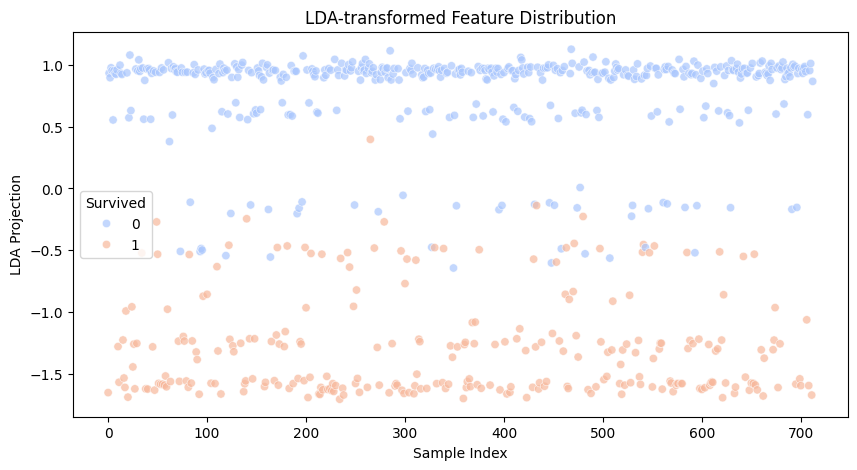

In [773]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(X_train_dr)), y=np.array(X_train_dr[0]).flatten(), hue=y_train, palette='coolwarm', alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("LDA Projection")
plt.title("LDA-transformed Feature Distribution")
plt.legend(title="Survived")
plt.show()
